# Part I: The Setup

In [41]:
import cards
import random
from collections import defaultdict

class BlackjackGame():
    def __init__(self):
        self.deck = cards.Deck()
        self.deck.shuffle()
        self.player_hand = cards.Hand()
        self.dealer_hand = cards.Hand()
        self.done = False

    def hit(self):
        self.player_hand.add_card(self.deck.draw())

    def stand(self):
        while self.dealer_hand.value() < 17:
            self.dealer_hand.add_card(self.deck.draw())

    def check_bust(self, hand: cards.Hand):
        return hand.value() > 21
    
    def check_blackjack(self, hand: cards.Hand):
        return hand.value() == 21 and len(hand.cards) == 2

    def initial_deal(self):
        self.player_hand.flush()
        self.dealer_hand.flush()

        if len(self.deck.cards) < 10:
            self.deck.reset()
        
        self.deck.shuffle()

        for _ in range(2):
            self.player_hand.add_card(self.deck.draw())
            self.dealer_hand.add_card(self.deck.draw())

    def winner(self):
        if self.check_bust(self.player_hand):
            return "Dealer wins! Player busted."
        if self.check_bust(self.dealer_hand):
            return "Player wins! Dealer busted."
        if self.check_blackjack(self.player_hand) and not self.check_blackjack(self.dealer_hand):
            return "Player wins with a Blackjack!"
        if self.check_blackjack(self.dealer_hand) and not self.check_blackjack(self.player_hand):
            return "Dealer wins with a Blackjack!"  
        if self.check_blackjack(self.player_hand) and self.check_blackjack(self.dealer_hand):
            return "Push! Both have Blackjack."
        if self.player_hand.value() > self.dealer_hand.value():
            return "Player wins!"   
        if self.player_hand.value() < self.dealer_hand.value():
            return "Dealer wins!"
        
        return "Push! It's a tie."
    
    def ace(self, hand: cards.Hand):
        values = [card.value for card in hand.cards]
        return "A" in values and hand.value() <= 21
    
    def card_value(self, card: cards.Card):
        if card.value in ["K", "Q", "J"]:
            return 10
        if card.value == "A":
            return 11
        return int(card.value)
    
    def get_state(self):
        return(self.player_hand.value(),
               self.ace(self.player_hand),
               self.dealer_hand.cards[0].value)
    
    def reset(self):
        self.initial_deal()
        self.done = False
        if self.check_blackjack(self.player_hand):
            self.done = True
        
        return self.get_state()
    
    def step(self, action: int):
        if self.done:
            raise Exception("Game is over. Please reset.")
        if action ==0:
            self.hit()

            if self.check_bust(self.player_hand):
                self.done = True
                reward = -1
                return self.get_state(), reward, self.done
            
            return self.get_state(), 0, self.done
        
        elif action ==1:
            self.stand()
            self.done = True

            result = self.winner()
            if "Player wins" in result:
                reward = 1
            elif "Dealer wins" in result:
                reward = -1
            else:
                reward = 0
            return self.get_state(), reward, self.done
        
        else:
            raise ValueError("Invalid")


# Part II: The Algorithms

## Monte Carlo Prediction


Defining the policy function:

In [42]:
def policy(state):
            if state[0] >= 20:
                return 1
            else:
                return 0       

In [43]:
N = 10_000

returns = defaultdict(list)
V = {}

for episode in range(N):
    game = BlackjackGame()
    state = game.reset()
    done = game.done
    episode_rewards = []
    episode_states = []

    while not done:
        episode_states.append(state)
        action = policy(state)
        next_state, reward, done = game.step(action)
        episode_rewards.append(reward)
        state = next_state

    G = 0
    visited_states = set()
    for t in reversed(range(len(episode_states))):
        G += episode_rewards[t]
        state = episode_states[t]
        
        if state not in visited_states:
            returns[state].append(G)
            visited_states.add(state)

        for state in returns:
            V[state] = sum(returns[state]) / len(returns[state])
        
def average_value(target_states):
    val = [V[s] for s in V if s[0] == target_states]
    return sum(val) / len(val) if val else 0

print( "State Value Estimates:")
print("V(21)= ", average_value(21))
print("V(5)= ", average_value(5))

State Value Estimates:
V(21)=  0.8239268588584956
V(5)=  -0.5274396543627312


## Monte Carlo Control

In [49]:
Q = defaultdict(lambda: {0: 0, 1: 0})

def greedy_action(state):
    max_q = max(Q[state].values())
    best_actions = [a for a in Q[state] if Q[state][a] == max_q]
    return random.choice(best_actions)

def epsilon_greedy_policy(state, epsilon):
    if random.random() < epsilon:
        return random.choice([0, 1])
    else:
        return greedy_action(state)

epsilon = 0.01
N = 500_000
alpha = 0.002
reward_history = []
for _ in range(N):
    game = BlackjackGame()
    state = game.reset()
    done = game.done
    if done:
        reward_history.append(0)
        continue
    episode = []

    while not done:
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done = game.step(action)
        episode.append((state, action, reward))
        state = next_state
    if episode:
        reward_history.append(episode[-1][2])
    else:
        reward_history.append(1)
    G = 0
    visited = set()
    for (s,a,r) in reversed(episode):
        G += r
        if (s,a) not in visited:
            Q[s][a] += alpha * (G - Q[s][a])
            visited.add((s,a))

## Visualisation

In [54]:
import numpy as np

def rolling_avg(data, window = 5000):
    return np.convolve(data, np.ones(window)/window, mode='valid')

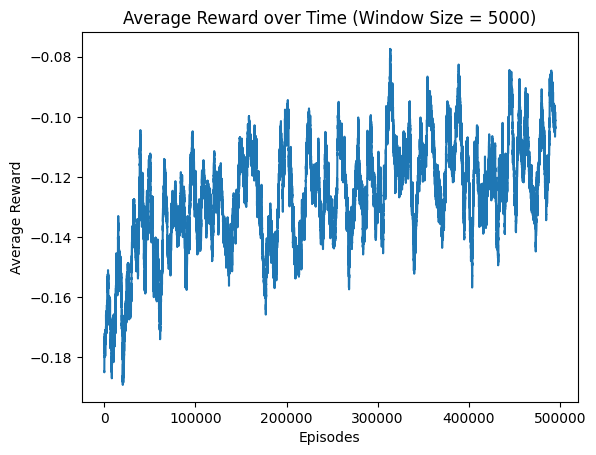

In [55]:
import matplotlib.pyplot as plt

window = 5000
avg_rewards = rolling_avg(reward_history, window)

plt.figure()
plt.plot(avg_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time (Window Size = {})'.format(window))
plt.show()

In [57]:
player_sums = range(4, 22)
dealer_showing = range(1, 11)

policy_grid = np.zeros((len(player_sums), len(dealer_showing)))

for i in range(len(player_sums)):
    for j in range(len(dealer_showing)):
        state = (player_sums[i], False, dealer_showing[j])
        if state in Q: 
            best_action = greedy_action(state)
            policy_grid[i, j] = best_action


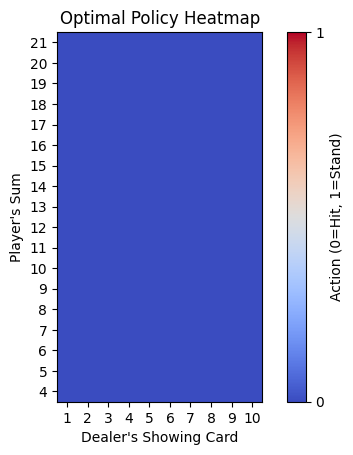

In [58]:
plt.figure()
plt.imshow(policy_grid, cmap='coolwarm', origin='lower')
plt.colorbar(ticks=[0, 1], label='Action (0=Hit, 1=Stand)')
plt.clim(0, 1)

plt.yticks(ticks=range(len(player_sums)), labels=player_sums)
plt.xticks(ticks=range(len(dealer_showing)), labels=dealer_showing)
plt.xlabel("Dealer's Showing Card")
plt.ylabel("Player's Sum")
plt.title("Optimal Policy Heatmap")
plt.show()